In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_train = pd.read_csv('./data/train_3406.csv')

In [3]:
data_test = pd.read_csv('./data/test_3406.csv')

In [4]:
#技術指標
#Moving Average  
def MA(df, n):  
    MA = df.rolling(n).mean()
    return MA

#均價線
def AVL(df):#, tick_N):
    AVL =  pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index, columns = ['AVL'])  
    AVL['AVL'] = np.cumsum(df['DealPrice']*df['DealQty']) / np.cumsum(df['DealQty'])
    AVL['%AVL'] = df['mid1'] / AVL['AVL'] - 1
    return AVL

#布林通道
def BBANDS(df, n, multiple, tick_N):  
    MA = df.rolling(n).mean()
    #%change
    MA_ = MA / MA.shift(tick_N) -1
    MSD = df.rolling(n).std()
    ub1 =  MA + multiple * MSD
    #%change
    ub1_ = ub1 / ub1.shift(tick_N) -1
    uB1 = pd.DataFrame(ub1_, index = df.index, columns = df.columns)  
    lb1 =  MA - multiple * MSD
    #%change
    lb1_ = lb1 / lb1.shift(tick_N) -1
    lB1 = pd.DataFrame(lb1_, index = df.index, columns = df.columns)  
    b2 = (df - MA + multiple * MSD) / (2 * multiple * MSD)  
    B2 = pd.DataFrame(b2, index = df.index, columns = df.columns)  
    BBAND = pd.concat([uB1, lB1, B2], keys = ['UpperBand', 'LowerBand', '%B'], axis = 1)
    BBAND.columns = ['UpperBand', 'LowerBand', '%B']
    return BBAND

#MACD, MACD Signal and MACD difference  
def MACD(df, n_fast, n_slow, C_price_name='mid1'):   
    EMAfast = df[C_price_name].ewm(span = n_fast, min_periods = n_slow - 1).mean() 
    EMAslow = df[C_price_name].ewm(span = n_slow, min_periods = n_slow - 1).mean() 
    #短EMA-長EMA
    MACD = pd.Series(EMAfast - EMAslow, name = 'MACD_' + str(n_fast) + '_' + str(n_slow))  
    MACDsign = pd.Series(MACD.ewm(span = 9, min_periods = 8).mean(), name = 'MACDsign_' + str(n_fast) + '_' + str(n_slow))  
    MACDdiff = pd.Series(MACD - MACDsign, name = 'MACDdiff_' + str(n_fast) + '_' + str(n_slow))  
    MACD = pd.concat([MACD, MACDsign, MACDdiff], axis = 1)
    return MACD

#generate features
def AlphaGenerate_Tick(original_data,bb=False,avl=False,spread=False,macd=False,price_diff=False,
                       price_mean=False,qty_mean=False,acc_diff=False,dt1p=False,dt5p=False,dt10p=False,
                      cross1=False,cross5=False,cross10=False,spread_pq=False,price_diff_pq=False,
                      spread_pct_pq=False,pq_mean=False,acc_diff_pq=False,dt1_pq=False,dt5_pq=False,dt10_pq=False,
                      ma=False,dt1q=False,dt5q=False,dt10q=False):
    ############################################################################################################################
    #需要預先處裡的東西放這邊
    #build Date column
    #original_data['Date'] = pd.to_datetime(original_data['TxTime'])
    #original_data['Date'] = [str(x)[0:10] for x in original_data['Date']]
    #df to save X
    X = pd.DataFrame()
    #copy
    data=original_data.copy()
    #mid
    data['mid1'] = (data['Ask1'] + data['Bid1']) / 2
    data['mid2'] = (data['Ask2'] + data['Bid2']) / 2
    data['mid3'] = (data['Ask3'] + data['Bid3']) / 2
    data['mid4'] = (data['Ask4'] + data['Bid4']) / 2
    data['mid5'] = (data['Ask5'] + data['Bid5']) / 2
    #some index's ask1 = 0, we change that mid1 to bid1
    idx = data[data['Ask1'] == 0].index
    for i in idx:
        data['mid1'].iloc[i] = data['Bid1'].iloc[i]
    #ask and askqty <-> bid and bidqty if one side = 0
    data['Ask1_'] = data['Ask1'].values
    data['Ask2_'] = data['Ask2'].values
    data['Ask3_'] = data['Ask3'].values
    data['Ask4_'] = data['Ask4'].values
    data['Ask5_'] = data['Ask5'].values
    data['Bid1_'] = data['Bid1'].values
    data['Bid2_'] = data['Bid2'].values
    data['Bid3_'] = data['Bid3'].values
    data['Bid4_'] = data['Bid4'].values
    data['Bid5_'] = data['Bid5'].values
    data['AskQty1_'] = data['AskQty1'].values
    data['AskQty2_'] = data['AskQty2'].values
    data['AskQty3_'] = data['AskQty3'].values
    data['AskQty4_'] = data['AskQty4'].values
    data['AskQty5_'] = data['AskQty5'].values
    data['BidQty1_'] = data['BidQty1'].values
    data['BidQty2_'] = data['BidQty2'].values
    data['BidQty3_'] = data['BidQty3'].values
    data['BidQty4_'] = data['BidQty4'].values
    data['BidQty5_'] = data['BidQty5'].values
    data['Ask1_'][data['Ask1_']==0]=data['Bid1_']
    data['Ask2_'][data['Ask2_']==0]=data['Bid2_']
    data['Ask3_'][data['Ask3_']==0]=data['Bid3_']
    data['Ask4_'][data['Ask4_']==0]=data['Bid4_']
    data['Ask5_'][data['Ask5_']==0]=data['Bid5_']
    data['AskQty1_'][data['AskQty1_']==0]=data['BidQty1_']
    data['AskQty2_'][data['AskQty2_']==0]=data['BidQty2_']
    data['AskQty3_'][data['AskQty3_']==0]=data['BidQty3_']
    data['AskQty4_'][data['AskQty4_']==0]=data['BidQty4_']
    data['AskQty5_'][data['AskQty5_']==0]=data['BidQty5_']
    data['Bid1_'][data['Bid1_']==0]=data['Ask1_']
    data['Bid2_'][data['Bid2_']==0]=data['Ask2_']
    data['Bid3_'][data['Bid3_']==0]=data['Ask3_']
    data['Bid4_'][data['Bid4_']==0]=data['Ask4_']
    data['Bid5_'][data['Bid5_']==0]=data['Ask5_']
    data['BidQty1_'][data['BidQty1_']==0]=data['AskQty1_']
    data['BidQty2_'][data['BidQty2_']==0]=data['AskQty2_']
    data['BidQty3_'][data['BidQty3_']==0]=data['AskQty3_']
    data['BidQty4_'][data['BidQty4_']==0]=data['AskQty4_']
    data['BidQty5_'][data['BidQty5_']==0]=data['AskQty5_']
    #df to save
    #df_date = pd.DataFrame()
    #date_idx = data['Date'].unique()
    #value(price*quantity)
    data['Ask1_value'] = data['Ask1_']*data['AskQty1_']
    data['Ask2_value'] = data['Ask2_']*data['AskQty2_']
    data['Ask3_value'] = data['Ask3_']*data['AskQty3_']
    data['Ask4_value'] = data['Ask4_']*data['AskQty4_']
    data['Ask5_value'] = data['Ask5_']*data['AskQty5_']
    data['Bid1_value'] = data['Bid1_']*data['BidQty1_']
    data['Bid2_value'] = data['Bid2_']*data['BidQty2_']
    data['Bid3_value'] = data['Bid3_']*data['BidQty3_']
    data['Bid4_value'] = data['Bid4_']*data['BidQty4_']
    data['Bid5_value'] = data['Bid5_']*data['BidQty5_']
    ############################################################################################################################
    #因子放這邊
    #不用考慮換日的因子 
    #MA
    if ma == True:
        X['MA50_ask1']=MA(data['Ask1_value'], 50)-data['Ask1_value']
        X['MA50_ask2']=MA(data['Ask2_value'], 50)-data['Ask2_value']
        X['MA50_ask3']=MA(data['Ask3_value'], 50)-data['Ask3_value']
        X['MA50_ask4']=MA(data['Ask4_value'], 50)-data['Ask4_value']
        X['MA50_ask5']=MA(data['Ask5_value'], 50)-data['Ask5_value']
        X['MA50_bid1']=MA(data['Bid1_value'], 50)-data['Bid1_value']
        X['MA50_bid2']=MA(data['Bid2_value'], 50)-data['Bid2_value']
        X['MA50_bid3']=MA(data['Bid3_value'], 50)-data['Bid3_value']
        X['MA50_bid4']=MA(data['Bid4_value'], 50)-data['Bid4_value']
        X['MA50_bid5']=MA(data['Bid5_value'], 50)-data['Bid5_value']
        X['MA100_ask1']=MA(data['Ask1_value'], 100)-data['Ask1_value']
        X['MA100_ask2']=MA(data['Ask2_value'], 100)-data['Ask2_value']
        X['MA100_ask3']=MA(data['Ask3_value'], 100)-data['Ask3_value']
        X['MA100_ask4']=MA(data['Ask4_value'], 100)-data['Ask4_value']
        X['MA100_ask5']=MA(data['Ask5_value'], 100)-data['Ask5_value']
        X['MA100_bid1']=MA(data['Bid1_value'], 100)-data['Bid1_value']
        X['MA100_bid2']=MA(data['Bid2_value'], 100)-data['Bid2_value']
        X['MA100_bid3']=MA(data['Bid3_value'], 100)-data['Bid3_value']
        X['MA100_bid4']=MA(data['Bid4_value'], 100)-data['Bid4_value']
        X['MA100_bid5']=MA(data['Bid5_value'], 100)-data['Bid5_value']
        X['MA10_ab1']=MA(data['Ask1_value'], 10) - MA(data['Bid1_value'], 10)
        X['MA10_ab2']=MA(data['Ask2_value'], 10) - MA(data['Bid2_value'], 10)
        X['MA10_ab3']=MA(data['Ask3_value'], 10) - MA(data['Bid3_value'], 10)
        X['MA10_ab4']=MA(data['Ask4_value'], 10) - MA(data['Bid4_value'], 10)
        X['MA10_ab5']=MA(data['Ask5_value'], 10) - MA(data['Bid5_value'], 10)
        X['MA20_ab1']=MA(data['Ask1_value'], 20) - MA(data['Bid1_value'], 20)
        X['MA20_ab2']=MA(data['Ask2_value'], 20) - MA(data['Bid2_value'], 20)
        X['MA20_ab3']=MA(data['Ask3_value'], 20) - MA(data['Bid3_value'], 20)
        X['MA20_ab4']=MA(data['Ask4_value'], 20) - MA(data['Bid4_value'], 20)
        X['MA20_ab5']=MA(data['Ask5_value'], 20) - MA(data['Bid5_value'], 20)
        X['MA30_ab1']=MA(data['Ask1_value'], 30) - MA(data['Bid1_value'], 30)
        X['MA30_ab2']=MA(data['Ask2_value'], 30) - MA(data['Bid2_value'], 30)
        X['MA30_ab3']=MA(data['Ask3_value'], 30) - MA(data['Bid3_value'], 30)
        X['MA30_ab4']=MA(data['Ask4_value'], 30) - MA(data['Bid4_value'], 30)
        X['MA30_ab5']=MA(data['Ask5_value'], 30) - MA(data['Bid5_value'], 30)
        X['MA50_ab1']=MA(data['Ask1_value'], 50) - MA(data['Bid1_value'], 50)
        X['MA50_ab2']=MA(data['Ask2_value'], 50) - MA(data['Bid2_value'], 50)
        X['MA50_ab3']=MA(data['Ask3_value'], 50) - MA(data['Bid3_value'], 50)
        X['MA50_ab4']=MA(data['Ask4_value'], 50) - MA(data['Bid4_value'], 50)
        X['MA50_ab5']=MA(data['Ask5_value'], 50) - MA(data['Bid5_value'], 50)
        X['MA100_ab1']=MA(data['Ask1_value'], 100) - MA(data['Bid1_value'], 100)
        X['MA100_ab2']=MA(data['Ask2_value'], 100) - MA(data['Bid2_value'], 100)
        X['MA100_ab3']=MA(data['Ask3_value'], 100) - MA(data['Bid3_value'], 100)
        X['MA100_ab4']=MA(data['Ask4_value'], 100) - MA(data['Bid4_value'], 100)
        X['MA100_ab5']=MA(data['Ask5_value'], 100) - MA(data['Bid5_value'], 100)
    #布林通道
    if bb == True:
        X = pd.concat([X, BBANDS(data[['mid1']], 100, 5, 10)], axis = 1)
    #均價線
    if avl == True:
        X = pd.concat([X, AVL(data)], axis = 1)
    #MACD
    if macd == True:
        X = pd.concat([X, MACD(data, 12, 26, C_price_name='mid1')], axis = 1)
    #spread of price
    if spread == True:
        X['spread1'] = data['Ask1_'] - data['Bid1_']
        X['spread2'] = data['Ask2_'] - data['Bid2_']
        X['spread3'] = data['Ask3_'] - data['Bid3_']
        X['spread4'] = data['Ask4_'] - data['Bid4_']
        X['spread5'] = data['Ask5_'] - data['Bid5_']
    #pct change of value
    #if spread_pct_pq == True:
    #    X['spread1_pct_pq'] = (data['Ask1_value'] / data['Bid1_value']) -1
    #    X['spread2_pct_pq'] = (data['Ask2_value'] / data['Bid2_value']) -1
    #    X['spread3_pct_pq'] = (data['Ask3_value'] / data['Bid3_value']) -1
    #    X['spread4_pct_pq'] = (data['Ask4_value'] / data['Bid4_value']) -1
    #    X['spread5_pct_pq'] = (data['Ask5_value'] / data['Bid5_value']) -1
    #spread of value
    if spread_pq == True:
        X['spread1_pq'] = data['Ask1_value'] - data['Bid1_value']
        X['spread2_pq'] = data['Ask2_value'] - data['Bid2_value'] 
        X['spread3_pq'] = data['Ask3_value'] - data['Bid3_value'] 
        X['spread4_pq'] = data['Ask4_value'] - data['Bid4_value'] 
        X['spread5_pq'] = data['Ask5_value'] - data['Bid5_value'] 
    #price diff
    if price_diff == True:
        X['a51_diff'] = data['Ask5_'] - data['Ask1_']
        X['b15_diff'] = data['Bid1_'] - data['Bid5_']
        X['a21_diff_abs'] = np.abs(data['Ask2_'] - data['Ask1_'])
        X['a32_diff_abs'] = np.abs(data['Ask3_'] - data['Ask2_'])
        X['a43_diff_abs'] = np.abs(data['Ask4_'] - data['Ask3_'])
        X['a54_diff_abs'] = np.abs(data['Ask5_'] - data['Ask4_'])
        X['b21_diff_abs'] = np.abs(data['Bid2_'] - data['Bid1_'])
        X['b32_diff_abs'] = np.abs(data['Bid3_'] - data['Bid2_'])
        X['b43_diff_abs'] = np.abs(data['Bid4_'] - data['Bid3_'])
        X['b54_diff_abs'] = np.abs(data['Bid5_'] - data['Bid4_'])
    #value diff
    if price_diff_pq == True:
        X['a51_diff_pq'] = data['Ask5_value'] - data['Ask1_value']
        X['b15_diff_pq'] = data['Bid1_value'] - data['Bid5_value']
        X['a21_diff_pq'] = data['Ask2_value'] - data['Ask1_value']
        X['a32_diff_pq'] = data['Ask3_value'] - data['Ask2_value']
        X['a43_diff_pq'] = data['Ask4_value'] - data['Ask3_value']
        X['a54_diff_pq'] = data['Ask5_value'] - data['Ask4_value']
        X['b21_diff_pq'] = data['Bid2_value'] - data['Bid1_value']
        X['b32_diff_pq'] = data['Bid3_value'] - data['Bid2_value']
        X['b43_diff_pq'] = data['Bid4_value'] - data['Bid3_value']
        X['b54_diff_pq'] = data['Bid5_value'] - data['Bid4_value']
    #price mean
    if price_mean == True:
        X['a_mean'] = (data['Ask1_'] +data['Ask2_'] +data['Ask3_'] +data['Ask4_'] +data['Ask5_']) / 5
        X['b_mean'] = (data['Bid1_'] +data['Bid2_'] +data['Bid3_'] +data['Bid4_'] +data['Bid5_']) / 5
    #quantity mean
    if qty_mean == True:
        X['aq_mean'] = (data['AskQty1_'] +data['AskQty2_'] +data['AskQty3_'] +data['AskQty4_'] +data['AskQty5_']) / 5
        X['bq_mean'] = (data['BidQty1_'] +data['BidQty2_'] +data['BidQty3_'] +data['BidQty4_'] +data['BidQty5_']) / 5
    #value mean
    if pq_mean == True:
        X['a_pq_mean'] = (data['Ask1_value']+data['Ask2_value']+data['Ask3_value']+data['Ask4_value']+data['Ask5_value'])/5
        X['b_pq_mean'] = (data['Bid1_value']+data['Bid2_value']+data['Bid3_value']+data['Bid4_value']+data['Bid5_value'])/5
    #accumulative difference of price and quantity
    if acc_diff == True:
        X['p_acc_diff'] = (data['Ask1_'] - data['Bid1_']) +(data['Ask2_'] - data['Bid2_']) + (data['Ask3_'] - data['Bid3_']) + (data['Ask4_'] - data['Bid4_']) + (data['Ask5_'] - data['Bid5_'])
        X['q_acc_diff'] = (data['AskQty1_'] - data['BidQty1_']) +(data['AskQty2_'] - data['BidQty2_']) + (data['AskQty3_'] - data['BidQty3_']) + (data['AskQty4_'] - data['BidQty4_']) + (data['AskQty5_'] - data['BidQty5_'])
    #value accumulative difference
    if acc_diff_pq == True:
        X['p_acc_diff_pq'] = (data['Ask1_value'] - data['Bid1_value']) +(data['Ask2_value'] - data['Bid2_value']) + (data['Ask3_value'] - data['Bid3_value']) + (data['Ask4_value'] - data['Bid4_value']) + (data['Ask5_value'] - data['Bid5_value'])
    ############################################################################################################################
    #要考慮換日的因子
    #shift 1 5 10 (price, quantity, value)
    if dt1p == True:
    #1 tick
        X['da1_dt_1'] = data['Ask1_']-data.groupby('Date')['Ask1_'].shift(1)
        X['da2_dt_1'] = data['Ask2_']-data.groupby('Date')['Ask2_'].shift(1)
        X['da3_dt_1'] = data['Ask3_']-data.groupby('Date')['Ask3_'].shift(1)
        X['da4_dt_1'] = data['Ask4_']-data.groupby('Date')['Ask4_'].shift(1)
        X['da5_dt_1'] = data['Ask5_']-data.groupby('Date')['Ask5_'].shift(1)
        X['db1_dt_1'] = data['Bid1_']-data.groupby('Date')['Bid1_'].shift(1)
        X['db2_dt_1'] = data['Bid2_']-data.groupby('Date')['Bid2_'].shift(1)
        X['db3_dt_1'] = data['Bid3_']-data.groupby('Date')['Bid3_'].shift(1)
        X['db4_dt_1'] = data['Bid4_']-data.groupby('Date')['Bid4_'].shift(1)
        X['db5_dt_1'] = data['Bid5_']-data.groupby('Date')['Bid5_'].shift(1)
        #fillna to 0
        X[['da1_dt_1','da2_dt_1','da3_dt_1','da4_dt_1','da5_dt_1','db1_dt_1','db2_dt_1','db3_dt_1','db4_dt_1','db5_dt_1']] = X[['da1_dt_1','da2_dt_1','da3_dt_1','da4_dt_1','da5_dt_1','db1_dt_1','db2_dt_1','db3_dt_1','db4_dt_1','db5_dt_1']].fillna(value = 0)
        
    if dt1_pq == True:
    #1 tick
        X['da1_dt_1_pq'] = data['Ask1_value']-data.groupby('Date')['Ask1_value'].shift(1)
        X['da2_dt_1_pq'] = data['Ask2_value']-data.groupby('Date')['Ask2_value'].shift(1)
        X['da3_dt_1_pq'] = data['Ask3_value']-data.groupby('Date')['Ask3_value'].shift(1)
        X['da4_dt_1_pq'] = data['Ask4_value']-data.groupby('Date')['Ask4_value'].shift(1)
        X['da5_dt_1_pq'] = data['Ask5_value']-data.groupby('Date')['Ask5_value'].shift(1)
        X['db1_dt_1_pq'] = data['Bid1_value']-data.groupby('Date')['Bid1_value'].shift(1)
        X['db2_dt_1_pq'] = data['Bid2_value']-data.groupby('Date')['Bid2_value'].shift(1)
        X['db3_dt_1_pq'] = data['Bid3_value']-data.groupby('Date')['Bid3_value'].shift(1)
        X['db4_dt_1_pq'] = data['Bid4_value']-data.groupby('Date')['Bid4_value'].shift(1)
        X['db5_dt_1_pq'] = data['Bid5_value']-data.groupby('Date')['Bid5_value'].shift(1)
    if dt5p == True:
    #5 ticks
        X['da1_dt_5'] = data['Ask1_']-data.groupby('Date')['Ask1_'].shift(5)
        X['da2_dt_5'] = data['Ask2_']-data.groupby('Date')['Ask2_'].shift(5)
        X['da3_dt_5'] = data['Ask3_']-data.groupby('Date')['Ask3_'].shift(5)
        X['da4_dt_5'] = data['Ask4_']-data.groupby('Date')['Ask4_'].shift(5)
        X['da5_dt_5'] = data['Ask5_']-data.groupby('Date')['Ask5_'].shift(5)
        X['db1_dt_5'] = data['Bid1_']-data.groupby('Date')['Bid1_'].shift(5)
        X['db2_dt_5'] = data['Bid2_']-data.groupby('Date')['Bid2_'].shift(5)
        X['db3_dt_5'] = data['Bid3_']-data.groupby('Date')['Bid3_'].shift(5)
        X['db4_dt_5'] = data['Bid4_']-data.groupby('Date')['Bid4_'].shift(5)
        X['db5_dt_5'] = data['Bid5_']-data.groupby('Date')['Bid5_'].shift(5)
        #fill na to 0
        X[['da1_dt_5','da2_dt_5','da3_dt_5','da4_dt_5','da5_dt_5','db1_dt_5','db2_dt_5','db3_dt_5','db4_dt_5','db5_dt_5']] = X[['da1_dt_5','da2_dt_5','da3_dt_5','da4_dt_5','da5_dt_5','db1_dt_5','db2_dt_5','db3_dt_5','db4_dt_5','db5_dt_5']].fillna(value = 0)
    if dt5_pq == True:
    #5 tick
        X['da1_dt_5_pq'] = data['Ask1_value']-data.groupby('Date')['Ask1_value'].shift(5)
        X['da2_dt_5_pq'] = data['Ask2_value']-data.groupby('Date')['Ask2_value'].shift(5)
        X['da3_dt_5_pq'] = data['Ask3_value']-data.groupby('Date')['Ask3_value'].shift(5)
        X['da4_dt_5_pq'] = data['Ask4_value']-data.groupby('Date')['Ask4_value'].shift(5)
        X['da5_dt_5_pq'] = data['Ask5_value']-data.groupby('Date')['Ask5_value'].shift(5)
        X['db1_dt_5_pq'] = data['Bid1_value']-data.groupby('Date')['Bid1_value'].shift(5)
        X['db2_dt_5_pq'] = data['Bid2_value']-data.groupby('Date')['Bid2_value'].shift(5)
        X['db3_dt_5_pq'] = data['Bid3_value']-data.groupby('Date')['Bid3_value'].shift(5)
        X['db4_dt_5_pq'] = data['Bid4_value']-data.groupby('Date')['Bid4_value'].shift(5)
        X['db5_dt_5_pq'] = data['Bid5_value']-data.groupby('Date')['Bid5_value'].shift(5)                                            
    if dt10p == True:
    #10 ticks
        X['da1_dt_10'] = data['Ask1_']-data.groupby('Date')['Ask1_'].shift(10)
        X['da2_dt_10'] = data['Ask2_']-data.groupby('Date')['Ask2_'].shift(10)
        X['da3_dt_10'] = data['Ask3_']-data.groupby('Date')['Ask3_'].shift(10)
        X['da4_dt_10'] = data['Ask4_']-data.groupby('Date')['Ask4_'].shift(10)
        X['da5_dt_10'] = data['Ask5_']-data.groupby('Date')['Ask5_'].shift(10)
        X['db1_dt_10'] = data['Bid1_']-data.groupby('Date')['Bid1_'].shift(10)
        X['db2_dt_10'] = data['Bid2_']-data.groupby('Date')['Bid2_'].shift(10)
        X['db3_dt_10'] = data['Bid3_']-data.groupby('Date')['Bid3_'].shift(10)
        X['db4_dt_10'] = data['Bid4_']-data.groupby('Date')['Bid4_'].shift(10)
        X['db5_dt_10'] = data['Bid5_']-data.groupby('Date')['Bid5_'].shift(10)
        #fill na to 0
        X[['da1_dt_10','da2_dt_10','da3_dt_10','da4_dt_10','da5_dt_10','db1_dt_10','db2_dt_10','db3_dt_10','db4_dt_10','db5_dt_10']] = X[['da1_dt_10','da2_dt_10','da3_dt_10','da4_dt_10','da5_dt_10','db1_dt_10','db2_dt_10','db3_dt_10','db4_dt_10','db5_dt_10']].fillna(value = 0)
    if dt10_pq == True:
    #10 tick
        X['da1_dt_10_pq'] = data['Ask1_value']-data.groupby('Date')['Ask1_value'].shift(10)
        X['da2_dt_10_pq'] = data['Ask2_value']-data.groupby('Date')['Ask2_value'].shift(10)
        X['da3_dt_10_pq'] = data['Ask3_value']-data.groupby('Date')['Ask3_value'].shift(10)
        X['da4_dt_10_pq'] = data['Ask4_value']-data.groupby('Date')['Ask4_value'].shift(10)
        X['da5_dt_10_pq'] = data['Ask5_value']-data.groupby('Date')['Ask5_value'].shift(10)
        X['db1_dt_10_pq'] = data['Bid1_value']-data.groupby('Date')['Bid1_value'].shift(10)
        X['db2_dt_10_pq'] = data['Bid2_value']-data.groupby('Date')['Bid2_value'].shift(10)
        X['db3_dt_10_pq'] = data['Bid3_value']-data.groupby('Date')['Bid3_value'].shift(10)
        X['db4_dt_10_pq'] = data['Bid4_value']-data.groupby('Date')['Bid4_value'].shift(10)
        X['db5_dt_10_pq'] = data['Bid5_value']-data.groupby('Date')['Bid5_value'].shift(10)                                           
    #quantity
    if dt1q == True:
    #1 tick
        X['daq1_dt_1'] = data['AskQty1_']-data.groupby('Date')['AskQty1_'].shift(1)
        X['daq2_dt_1'] = data['AskQty2_']-data.groupby('Date')['AskQty2_'].shift(1)
        X['daq3_dt_1'] = data['AskQty3_']-data.groupby('Date')['AskQty3_'].shift(1)
        X['daq4_dt_1'] = data['AskQty4_']-data.groupby('Date')['AskQty4_'].shift(1)
        X['daq5_dt_1'] = data['AskQty5_']-data.groupby('Date')['AskQty5_'].shift(1)
        X['dbq1_dt_1'] = data['BidQty1_']-data.groupby('Date')['BidQty1_'].shift(1)
        X['dbq2_dt_1'] = data['BidQty2_']-data.groupby('Date')['BidQty2_'].shift(1)
        X['dbq3_dt_1'] = data['BidQty3_']-data.groupby('Date')['BidQty3_'].shift(1)
        X['dbq4_dt_1'] = data['BidQty4_']-data.groupby('Date')['BidQty4_'].shift(1)
        X['dbq5_dt_1'] = data['BidQty5_']-data.groupby('Date')['BidQty5_'].shift(1)
        #fill na to 0
        X[['daq1_dt_1','daq2_dt_1','daq3_dt_1','daq4_dt_1','daq5_dt_1','dbq1_dt_1','dbq2_dt_1','dbq3_dt_1','dbq4_dt_1','dbq5_dt_1']] = X[['daq1_dt_1','daq2_dt_1','daq3_dt_1','daq4_dt_1','daq5_dt_1','dbq1_dt_1','dbq2_dt_1','dbq3_dt_1','dbq4_dt_1','dbq5_dt_1']].fillna(value = 0)
    if dt5q == True:
    #5 ticks
        X['daq1_dt_5'] = data['AskQty1_']-data.groupby('Date')['AskQty1_'].shift(5)
        X['daq2_dt_5'] = data['AskQty2_']-data.groupby('Date')['AskQty2_'].shift(5)
        X['daq3_dt_5'] = data['AskQty3_']-data.groupby('Date')['AskQty3_'].shift(5)
        X['daq4_dt_5'] = data['AskQty4_']-data.groupby('Date')['AskQty4_'].shift(5)
        X['daq5_dt_5'] = data['AskQty5_']-data.groupby('Date')['AskQty5_'].shift(5)
        X['dbq1_dt_5'] = data['BidQty1_']-data.groupby('Date')['BidQty1_'].shift(5)
        X['dbq2_dt_5'] = data['BidQty2_']-data.groupby('Date')['BidQty2_'].shift(5)
        X['dbq3_dt_5'] = data['BidQty3_']-data.groupby('Date')['BidQty3_'].shift(5)
        X['dbq4_dt_5'] = data['BidQty4_']-data.groupby('Date')['BidQty4_'].shift(5)
        X['dbq5_dt_5'] = data['BidQty5_']-data.groupby('Date')['BidQty5_'].shift(5)
        #fill na to 0
        X[['daq1_dt_5','daq2_dt_5','daq3_dt_5','daq4_dt_5','daq5_dt_5','dbq1_dt_5','dbq2_dt_5','dbq3_dt_5','dbq4_dt_5','dbq5_dt_5']] = X[['daq1_dt_5','daq2_dt_5','daq3_dt_5','daq4_dt_5','daq5_dt_5','dbq1_dt_5','dbq2_dt_5','dbq3_dt_5','dbq4_dt_5','dbq5_dt_5']].fillna(value = 0)
    if dt10q == True:
    #10 ticks
        X['daq1_dt_10'] = data['AskQty1_']-data.groupby('Date')['AskQty1_'].shift(10)
        X['daq2_dt_10'] = data['AskQty2_']-data.groupby('Date')['AskQty2_'].shift(10)
        X['daq3_dt_10'] = data['AskQty3_']-data.groupby('Date')['AskQty3_'].shift(10)
        X['daq4_dt_10'] = data['AskQty4_']-data.groupby('Date')['AskQty4_'].shift(10)
        X['daq5_dt_10'] = data['AskQty5_']-data.groupby('Date')['AskQty5_'].shift(10)
        X['dbq1_dt_10'] = data['BidQty1_']-data.groupby('Date')['BidQty1_'].shift(10)
        X['dbq2_dt_10'] = data['BidQty2_']-data.groupby('Date')['BidQty2_'].shift(10)
        X['dbq3_dt_10'] = data['BidQty3_']-data.groupby('Date')['BidQty3_'].shift(10)
        X['dbq4_dt_10'] = data['BidQty4_']-data.groupby('Date')['BidQty4_'].shift(10)
        X['dbq5_dt_10'] = data['BidQty5_']-data.groupby('Date')['BidQty5_'].shift(10)
        #fill na to 0
        X[['daq1_dt_10','daq2_dt_10','daq3_dt_10','daq4_dt_10','daq5_dt_10','dbq1_dt_10','dbq2_dt_10','dbq3_dt_10','dbq4_dt_10','dbq5_dt_10']] = X[['daq1_dt_10','daq2_dt_10','daq3_dt_10','daq4_dt_10','daq5_dt_10','dbq1_dt_10','dbq2_dt_10','dbq3_dt_10','dbq4_dt_10','dbq5_dt_10']].fillna(value = 0)    
    #features crosses
    #dt1
    if (cross1 == True) and (dt1p == True) and (dt1q == True):
        #ask
        X['aq1dt1_cross'] = X['da1_dt_1'] * X['daq1_dt_1']
        X['aq2dt1_cross'] = X['da2_dt_1'] * X['daq2_dt_1']
        X['aq3dt1_cross'] = X['da3_dt_1'] * X['daq3_dt_1']
        X['aq4dt1_cross'] = X['da4_dt_1'] * X['daq4_dt_1']
        X['aq5dt1_cross'] = X['da5_dt_1'] * X['daq5_dt_1']
        #bid
        X['bq1dt1_cross'] = X['db1_dt_1'] * X['dbq1_dt_1']
        X['bq2dt1_cross'] = X['db2_dt_1'] * X['dbq2_dt_1']
        X['bq3dt1_cross'] = X['db3_dt_1'] * X['dbq3_dt_1']
        X['bq4dt1_cross'] = X['db4_dt_1'] * X['dbq4_dt_1']
        X['bq5dt1_cross'] = X['db5_dt_1'] * X['dbq5_dt_1']
    #dt5
    if (cross5 == True) and (dt5p == True) and (dt5q == True):
        #ask
        X['aq1dt5_cross'] = X['da1_dt_5'] * X['daq1_dt_5']
        X['aq2dt5_cross'] = X['da2_dt_5'] * X['daq2_dt_5']
        X['aq3dt5_cross'] = X['da3_dt_5'] * X['daq3_dt_5']
        X['aq4dt5_cross'] = X['da4_dt_5'] * X['daq4_dt_5']
        X['aq5dt5_cross'] = X['da5_dt_5'] * X['daq5_dt_5']
        #bid
        X['bq1dt5_cross'] = X['db1_dt_5'] * X['dbq1_dt_5']
        X['bq2dt5_cross'] = X['db2_dt_5'] * X['dbq2_dt_5']
        X['bq3dt5_cross'] = X['db3_dt_5'] * X['dbq3_dt_5']
        X['bq4dt5_cross'] = X['db4_dt_5'] * X['dbq4_dt_5']
        X['bq5dt5_cross'] = X['db5_dt_5'] * X['dbq5_dt_5']
    #dt10
    if (cross10 == True) and (dt10p == True) and (dt10q == True):
        #ask
        X['aq1dt10_cross'] = X['da1_dt_10'] * X['daq1_dt_10']
        X['aq2dt10_cross'] = X['da2_dt_10'] * X['daq2_dt_10']
        X['aq3dt10_cross'] = X['da3_dt_10'] * X['daq3_dt_10']
        X['aq4dt10_cross'] = X['da4_dt_10'] * X['daq4_dt_10']
        X['aq5dt10_cross'] = X['da5_dt_10'] * X['daq5_dt_10']
        #bid
        X['bq1dt10_cross'] = X['db1_dt_10'] * X['dbq1_dt_10']
        X['bq2dt10_cross'] = X['db2_dt_10'] * X['dbq2_dt_10']
        X['bq3dt10_cross'] = X['db3_dt_10'] * X['dbq3_dt_10']
        X['bq4dt10_cross'] = X['db4_dt_10'] * X['dbq4_dt_10']
        X['bq5dt10_cross'] = X['db5_dt_10'] * X['dbq5_dt_10']
    df = pd.concat([data, X], axis = 1)
    df = df.dropna()
    df = df.reset_index(drop = True)
    X = X.dropna()
    X = X.reset_index(drop = True)
    return X, df

#normalize
def normalize(df):
    norm = df.apply(lambda x: x / (np.std(x)))
    return norm

#scale back to the true range
def true_range(df, x, response):
    X = x * np.std(df[response])
    return X

#rolling windows
def train_windows(df, response, ref_day=10, predict_day=1):
    X_train, Y_train = [], []
    for i in range(df.shape[0]-predict_day-ref_day+1):
        #扣掉response
        #記得最後一行要放response
        X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        Y_train.append(np.array(df.iloc[i+ref_day-1:i+ref_day][response]))
    return np.array(X_train), np.array(Y_train)

#LSTM (when add the drop out layer in order to deal with overfitting)
def lstm_stock_model(shape):
    model = Sequential()
    #return sequence = True -> means the network will have long memory
    #first layer
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    #first drop out layer(drop 50% of the previous one to avoid over-fitting)
    model.add(Dropout(0.5))
    #second layer
    model.add(LSTM(256, return_sequences=True))
    #second drop out layer
    model.add(Dropout(0.5))
    #add dense in every time step, dimension -> 1
    model.add(TimeDistributed(Dense(1)))
    #third drop out layer
    model.add(Dropout(0.5))
    #flatten: 多維 -> 一維
    model.add(Flatten())
    #forth drop out layer
    #model.add(Dropout(0.5))
    #dense layer
    model.add(Dense(10,activation='linear'))
    #1 -> output dimension
    model.add(Dense(1,activation='linear'))
    #change learning rate 0.001 -> 0.0005
    adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
    model.compile(loss="mean_squared_error", optimizer=adam,metrics=['mean_squared_error'])
    #using MSE
    #model.compile(loss="mean_squared_error", optimizer="adam",metrics=['mean_squared_error'])
    model.summary()
    return model

#record transaction
def record_transaction(para, date, tick, action_side, price, equity_value, transaction_history):
    info = {
                'Date': date,
                'tick': tick,
                'Action': action_side,
                'Price': price,
                'Equity_value': equity_value
            }
    if para in transaction_history:
        transaction_history[para].append(info)
    else:
        transaction_history.update({para: [info]})    
    
    return transaction_history

#performance
def performance(equity_value_, transaction):
    #return
    Return = equity_value_.iloc[-1][0]
    print('return:', Return)
    #vol
    Std = equity_value_.std()[0]
    print('std:', Std)
    #sharp ratio
    Sharp_ratio = (Return - 0.0052) / Std
    print('sharp ratio:', Sharp_ratio)
    #nums of trading
    Trades = len(transaction) / 2
    print('trades:', Trades)
    #odds ratio
    R = 0
    for i in range(len(transaction)):
        if transaction[i]['Equity_value'] > 0:
            R += 1
    Odd = R / (len(transaction) / 2)
    print('odds ratio:', Odd)
    #mdd
    Mdd = (equity_value_.cummax() - equity_value_).max()[0]
    print('mdd:', Mdd)
    #skew
    Skew = equity_value_.skew()[0]
    print('skewness:', Skew)
     
    return Return, Std, Sharp_ratio, Trades, Odd, Mdd, Skew

#model performance
def model_performance(y, f):
    tot = np.sum(np.square(y - np.mean(y)))
    res = np.sum(np.square(y - f))
    r_squared = 1 - res / tot
    mse = np.mean(np.square(y - f)) * (1 / len(y))
    print('MSE:', mse)
    print('r-squared:', r_squared)
    return r_squared

#strategy
def strategy(df_train, paras):
    #adding hard stop 
    #main strategy (train set)
    #record transaction
    transaction_history1 = {}
    #record equity values
    equity_value_1 = pd.DataFrame()
    #record each returns
    #each_return1 = pd.DataFrame()
    #record unrealized gain
    unrealized_1 = pd.DataFrame()
    for l in range(len(paras)):
        df_train['side'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
        for j in range(len(df_train)):
            if df_train['pred_return'].iloc[j] > paras[l][0]:
                #long side
                df_train['side'].iloc[j] = 1
            elif df_train['pred_return'].iloc[j] < paras[l][1]:
                #short side
                df_train['side'].iloc[j] = -1
        date_idx = df_train['Date'].unique()
        #紀錄已實現
        equity_value1 = pd.DataFrame()
        #紀錄未實現
        unrealized1 = pd.DataFrame()
        for k in date_idx:
            df = df_train[df_train.Date == k]
            #side = 0
            for i in range(len(df)):
                #first tick
                if i == 0:
                    #ask1 may be 0, which means 漲停 (買不到)
                    if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                        #side = 1
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = 0
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    elif (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                        side = 0
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = 0
                    elif df['side'].iloc[i] == -1:
                        #side = -1
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = - 0.0015
                        df['unrealized'].iloc[i] = -0.0015
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        #side = 0
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = 0
                #last tick
                elif i == (len(df) - 1):
                    if df['holding'].iloc[i-1] == 1:
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                        df['unrealized'].iloc[i] = (df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) - 0.0015 
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #ask1 may be 0, which means 漲停 (買不到)
                    elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] != 0):
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #收盤如果漲停，空單結不掉，先用mid1結
                    elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] == 0):
                        df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['mid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    else:
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = 0
                else:
                    if df['holding'].iloc[i-1] == 1:
                        #hard stop 1 -1 = 0 -> 0
                        if ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > paras[l][2]):
                            df['holding'].iloc[i] = 0
                            df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                            df['unrealized'].iloc[i] = (df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) - 0.0015 
                            transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                        #change side 1 -2 -> -1
                        elif (df['side'].iloc[i] == -1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > 0.01):
                            df['holding'].iloc[i] = -1
                            df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - (0.0015 * 2)
                            df['unrealized'].iloc[i] = (df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) - (0.0015 * 2) 
                            transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i] + 0.0015, transaction_history1)
                            transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                        else:
                            df['holding'].iloc[i] = df['holding'].iloc[i-1]
                            df['equity_value'].iloc[i] = 0
                            df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) 
                    elif df['holding'].iloc[i-1] == -1:
                        #hard stop -1 +1 -> 0
                        if (df['Ask1'].iloc[i] != 0) and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > paras[l][2])):
                            df['holding'].iloc[i] = 0
                            df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                            df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                            transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                        #change side -1 +2 -> 1
                        elif (df['Ask1'].iloc[i] != 0) and (df['side'].iloc[i] == 1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > 0.01):
                            df['holding'].iloc[i] = 1
                            df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                            df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                            transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                            transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                        else:
                            df['holding'].iloc[i] = df['holding'].iloc[i-1]
                            df['equity_value'].iloc[i] = 0
                            df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                    elif df['holding'].iloc[i-1] == 0:
                        if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                            df['holding'].iloc[i] = 1
                            df['equity_value'].iloc[i] = 0
                            df['unrealized'].iloc[i] = 0
                            transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                        elif df['side'].iloc[i] == -1:
                            df['holding'].iloc[i] = -1
                            df['equity_value'].iloc[i] = - 0.0015
                            df['unrealized'].iloc[i] = -0.0015 
                            transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                        else:
                            df['holding'].iloc[i] = 0
                            df['equity_value'].iloc[i] = 0
                            df['unrealized'].iloc[i] = 0
            equity_value1 = pd.concat([equity_value1, df[['equity_value']]])
            #if k == date_idx[0]:
            unrealized1 = pd.concat([unrealized1, df[['unrealized']]])
            #else:
            #    unrealized_1 = pd.concat([unrealized_1, df['unrealized'] + unrealized_1.iloc[len(unrealized_1) - 1]])
        #concat
        equity_value_1 = pd.concat([equity_value_1, np.cumsum(equity_value1)], axis = 1)
        #each_return1 = pd.concat([each_return1, equity_value1], axis = 1)
    
        unrealized_1 = pd.concat([unrealized_1, unrealized1], axis = 1)
    return equity_value_1, unrealized_1, transaction_history1

#unrealized return
def unrealized(equity_value_1, unrealized_1):
    idx = []
    for i in range(len(equity_value_1) - 1):
        if (equity_value_1.iloc[i] != equity_value_1.iloc[i+1]) and (equity_value_1.iloc[i+1] != -0.0015):
            idx.append(i+1)
    unrealized_return = pd.DataFrame()
    for i in range(len(idx)):
        if i == 0:
            unrealized_1.iloc[[idx[i]]] = equity_value_1.iloc[[idx[i]]]
            unrealized_return = pd.concat([unrealized_return, np.cumsum(unrealized_1.iloc[:idx[i]])])
        else:
            unrealized_1.iloc[[idx[i]]] = equity_value_1.iloc[[idx[i]]]
            unrealized_return = pd.concat([unrealized_return, np.cumsum(unrealized_1.iloc[idx[i-1]:idx[i]])])
    return unrealized_return

In [5]:
data_train['Date'] = pd.to_datetime(data_train['TxTime'])
data_train['Date'] = [str(x)[0:10] for x in data_train['Date']]
data_test['Date'] = pd.to_datetime(data_test['TxTime'])
data_test['Date'] = [str(x)[0:10] for x in data_test['Date']]

In [6]:
#drop 3/23 3/24, 資料有缺值 9:22 -> 9:41
data_train = data_train[data_train.Date != '2020-03-23']
data_train = data_train[data_train.Date != '2020-03-24']
data_train = data_train.reset_index(drop = True)

In [7]:
X_in, data_train1 = AlphaGenerate_Tick(data_train,ma=True,macd=True,
                                      spread_pq=True,price_diff_pq=True,
                                      dt5_pq=True,dt10_pq=True,
                                      dt5q=True,dt10q=True,dt5p=True,dt10p=True)
X_in

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipyke

,MA50_ask1,MA50_ask2,MA50_ask3,MA50_ask4,MA50_ask5,MA50_bid1,MA50_bid2,MA50_bid3,MA50_bid4,MA50_bid5,...,daq1_dt_10,daq2_dt_10,daq3_dt_10,daq4_dt_10,daq5_dt_10,dbq1_dt_10,dbq2_dt_10,dbq3_dt_10,dbq4_dt_10,dbq5_dt_10
0,29218.77,-29412.64,15014.88,-12735.12,2499.20,2846.61,4551.72,-8129.72,803.09,1703.76,...,-128.0,119.0,-48.0,50.0,-4.0,0.0,-2.0,2.0,0.0,0.0
1,28515.43,-28463.08,14606.82,-12335.16,2467.08,2798.75,4567.52,-7805.86,858.15,1640.35,...,-125.0,119.0,-48.0,50.0,-4.0,0.0,-2.0,2.0,0.0,0.0
2,27812.11,-27513.52,14198.76,-11935.20,2434.96,2750.89,4583.32,-7482.00,913.21,1576.94,...,-5.0,-5.0,0.0,0.0,0.0,-4.0,-37.0,33.0,8.0,-5.0
3,27881.89,20753.38,-32713.74,7283.70,-17195.20,2726.94,4599.12,-7158.14,968.27,1513.53,...,-8.0,-121.0,119.0,-48.0,50.0,-4.0,-37.0,33.0,8.0,-5.0
4,25585.57,-26580.06,14380.20,-11519.34,2770.68,2726.91,4614.94,-6842.20,967.91,1205.40,...,-4.0,0.0,0.0,0.0,0.0,-4.0,-37.0,33.0,8.0,-5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386276,-2557.66,-4052.13,-2466.21,1903.25,1381.49,1583.13,-2066.18,1474.48,-1795.73,1338.74,...,7.0,22.0,8.0,-13.0,-4.0,-17.0,14.0,-9.0,10.0,-11.0
386277,-2530.97,-3856.54,-2208.09,1796.63,1319.26,1849.50,-1942.04,1386.18,-1680.75,1241.80,...,7.0,22.0,8.0,-13.0,-4.0,-18.0,14.0,-9.0,11.0,-11.0
386278,-2504.28,-3660.95,-2386.07,1681.11,1257.03,1672.37,-1817.90,1297.88,-1565.77,1144.86,...,7.0,0.0,1.0,0.0,0.0,6.0,-1.0,0.0,0.0,0.0
386279,-2477.59,-3465.36,-2119.05,1565.59,1194.80,2807.99,-1693.76,1209.58,-1450.79,1047.92,...,7.0,0.0,1.0,0.0,0.0,-2.0,-1.0,0.0,0.0,0.0


In [8]:
#X_in_normal = normalize(X_in.iloc[:,34:])
#Y
tick_N = 10
y=(data_train1['Ask1']+data_train1['Bid1'])/2
y[data_train1['Bid1']==0]=data_train1['Ask1']
y[data_train1['Ask1']==0]=data_train1['Bid1']
y=y.shift(-tick_N)/y-1
y[data_train1['Date']!=data_train1['Date'].shift(-tick_N)]=0.
y.fillna(0,inplace=True)
y.replace([np.inf, -np.inf], 0,inplace=True)
#X_in_normal['return_10t'] = y
X_in['return_10t'] = y
X_in_normal = normalize(X_in)

In [9]:
#test set
X_out, data_test1 = AlphaGenerate_Tick(data_test,ma=True,macd=True,
                                      spread_pq=True,price_diff_pq=True,
                                      dt5_pq=True,dt10_pq=True,
                                      dt5q=True,dt10q=True,dt5p=True,dt10p=True)
#X_out_normal = normalize(X_out.iloc[:,34:])
#Y
y=(data_test1['Ask1']+data_test1['Bid1'])/2
y[data_test1['Bid1']==0]=data_test1['Ask1']
y[data_test1['Ask1']==0]=data_test1['Bid1']
y=y.shift(-tick_N)/y-1
y[data_test1['Date']!=data_test1['Date'].shift(-tick_N)]=0.
y.fillna(0,inplace=True)
y.replace([np.inf, -np.inf], 0,inplace=True)
#X_out_normal['return_10t'] = y
X_out['return_10t'] = y
X_out_normal = normalize(X_out)

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipyke

In [10]:
train_pred_return = pd.read_csv('./data/train_return_mix3.csv')
test_pred_return  = pd.read_csv('./data/test_return_mix3.csv')

In [11]:
train_pred_return = train_pred_return.drop(['Unnamed: 0'], axis = 1)
train_pred_return.columns = ['pred_return']
train_pred_return

,pred_return
0,0.000157
1,0.000121
2,-0.000006
3,-0.000194
4,-0.000329
...,...
385867,-0.000105
385868,-0.000094
385869,-0.000122
385870,-0.000154


In [12]:
test_pred_return = test_pred_return.drop(['Unnamed: 0'], axis = 1)
test_pred_return.columns = ['pred_return']
test_pred_return

,pred_return
0,-0.000057
1,-0.000046
2,-0.000050
3,-0.000058
4,-0.000091
...,...
106350,0.000062
106351,0.000035
106352,0.000025
106353,0.000025


In [13]:
df_train = X_in.iloc[10:]
df_train = df_train.reset_index(drop = True)
df_train = pd.concat([df_train, train_pred_return], axis = 1)
df_train['Date'] = data_train1['Date'].iloc[10:].values
df_train['Ask1'] = data_train1['Ask1'].iloc[10:].values
df_train['Bid1'] = data_train1['Bid1'].iloc[10:].values
df_train['mid1'] = data_train1['mid1'].iloc[10:].values

In [14]:
df_test = X_out.iloc[10:]
df_test = df_test.reset_index(drop = True)
df_test = pd.concat([df_test, test_pred_return], axis = 1)
df_test['Date'] = data_test1['Date'].iloc[10:].values
df_test['Ask1'] = data_test1['Ask1'].iloc[10:].values
df_test['Bid1'] = data_test1['Bid1'].iloc[10:].values
df_test['mid1'] = data_test1['mid1'].iloc[10:].values

In [15]:
np.sum(df_train['pred_return'] > 0.001)

145

In [16]:
np.sum(df_train['pred_return'] < -0.001)

381

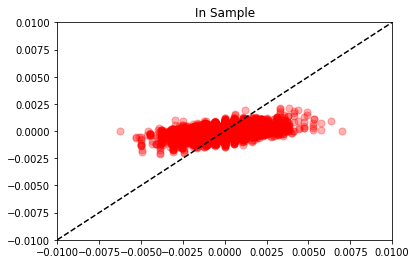

In [17]:
plt.scatter(df_train['return_10t'], df_train['pred_return'], s=50, c='red', alpha=.3)
plt.title('In Sample')
plt.ylim(-0.01, 0.01)
plt.xlim(-0.01, 0.01)
x = [-0.01, 0.01]
plt.plot(x, x, 'k--')

Text(0.5, 1.0, 'Predicted Return (train)')

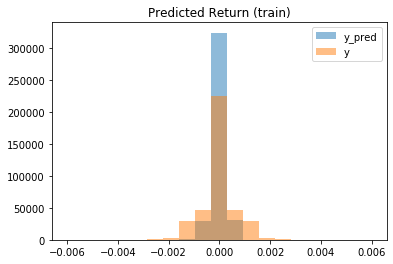

In [18]:
bins = np.linspace(-0.006, 0.006, 20)
plt.hist(df_train['pred_return'], bins, alpha=0.5, label='y_pred')
plt.hist(df_train['return_10t'], bins, alpha=0.5, label='y')
plt.legend(loc='upper right')
plt.title('Predicted Return (train)')

In [17]:
np.sum(df_test['pred_return'] > 0.0008)

56

In [27]:
np.sum(df_test['pred_return'] < -0.0008)

176

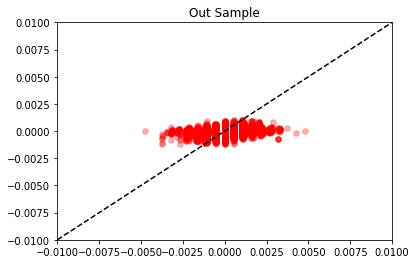

In [18]:
plt.scatter(df_test['return_10t'], df_test['pred_return'], s=30, c='red', alpha=.3)
plt.title('Out Sample')
plt.ylim(-0.01, 0.01)
plt.xlim(-0.01, 0.01)
x = [-0.01, 0.01]
plt.plot(x, x, 'k--')

Text(0.5, 1.0, 'Predicted Return (test)')

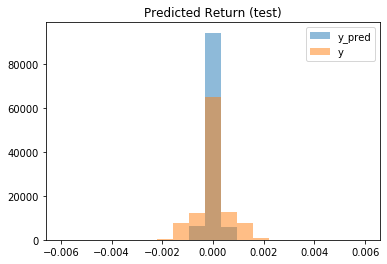

In [22]:
bins = np.linspace(-0.006, 0.006, 20)
plt.hist(df_test['pred_return'], bins, alpha=0.5, label='y_pred')
plt.hist(df_test['return_10t'], bins, alpha=0.5, label='y')
plt.legend(loc='upper right')
plt.title('Predicted Return (test)')

In [20]:
#已實現損益
df_train['equity_value'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
#未實現損益
df_train['unrealized'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
df_train['holding'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])

In [21]:
#已實現損益
df_test['equity_value'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])
#未實現損益
df_test['unrealized'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])
df_test['holding'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])

In [28]:
#setting parameters
import itertools 
long_side, short_side, stop_1 = [0.0008, 0.001, 0.0015, 0.002], [-0.0008, -0.001, -0.0015, -0.002], [-0.015, -0.02, -0.025]
paras = list(itertools.product(long_side, short_side, stop_1))
paras

[(0.0008, -0.0008, -0.015),
 (0.0008, -0.0008, -0.02),
 (0.0008, -0.0008, -0.025),
 (0.0008, -0.001, -0.015),
 (0.0008, -0.001, -0.02),
 (0.0008, -0.001, -0.025),
 (0.0008, -0.0015, -0.015),
 (0.0008, -0.0015, -0.02),
 (0.0008, -0.0015, -0.025),
 (0.0008, -0.002, -0.015),
 (0.0008, -0.002, -0.02),
 (0.0008, -0.002, -0.025),
 (0.001, -0.0008, -0.015),
 (0.001, -0.0008, -0.02),
 (0.001, -0.0008, -0.025),
 (0.001, -0.001, -0.015),
 (0.001, -0.001, -0.02),
 (0.001, -0.001, -0.025),
 (0.001, -0.0015, -0.015),
 (0.001, -0.0015, -0.02),
 (0.001, -0.0015, -0.025),
 (0.001, -0.002, -0.015),
 (0.001, -0.002, -0.02),
 (0.001, -0.002, -0.025),
 (0.0015, -0.0008, -0.015),
 (0.0015, -0.0008, -0.02),
 (0.0015, -0.0008, -0.025),
 (0.0015, -0.001, -0.015),
 (0.0015, -0.001, -0.02),
 (0.0015, -0.001, -0.025),
 (0.0015, -0.0015, -0.015),
 (0.0015, -0.0015, -0.02),
 (0.0015, -0.0015, -0.025),
 (0.0015, -0.002, -0.015),
 (0.0015, -0.002, -0.02),
 (0.0015, -0.002, -0.025),
 (0.002, -0.0008, -0.015),
 (0.002

In [29]:
#adding hard stop 
#main strategy (train set)
#record transaction
transaction_history1 = {}
#record equity values
equity_value_1 = pd.DataFrame()
#record each returns
each_return1 = pd.DataFrame()
#record unrealized gain
unrealized_1 = pd.DataFrame()
for l in range(len(paras)):
    df_train['side'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
    for j in range(len(df_train)):
        if df_train['pred_return'].iloc[j] > paras[l][0]:
            #long side
            df_train['side'].iloc[j] = 1
        elif df_train['pred_return'].iloc[j] < paras[l][1]:
            #short side
            df_train['side'].iloc[j] = -1
    date_idx = df_train['Date'].unique()
    #紀錄已實現
    equity_value1 = pd.DataFrame()
    #紀錄未實現
    unrealized1 = pd.DataFrame()
    for k in date_idx:
        df = df_train[df_train.Date == k]
        #side = 0
        for i in range(len(df)):
            #first tick
            if i == 0:
                #ask1 may be 0, which means 漲停 (買不到)
                if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                    #side = 1
                    df['holding'].iloc[i] = 1
                    #stock_price = df['Ask1'].iloc[i]
                    df['equity_value'].iloc[i] = 0
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                elif (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                    side = 0
                    df['equity_value'].iloc[i] = 0
                elif df['side'].iloc[i] == -1:
                    #side = -1
                    df['holding'].iloc[i] = -1
                    #stock_price = df['Bid1'].iloc[i]
                    df['equity_value'].iloc[i] = - 0.0015
                    df['unrealized'].iloc[i] = -0.0015
                    transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                else:
                    #side = 0
                    df['holding'].iloc[i] = 0
                    df['equity_value'].iloc[i] = 0
            #last tick
            elif i == (len(df) - 1):
                if df['holding'].iloc[i-1] == 1:
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                    transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                #ask1 may be 0, which means 漲停 (買不到)
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] != 0):
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                #收盤如果漲停，空單結不掉，先用mid1結
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] == 0):
                    df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['mid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                else:
                    df['equity_value'].iloc[i] = 0
            else:
                if df['holding'].iloc[i-1] == 1:
                    #hard stop 1 -1 = 0 -> 0
                    if ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > paras[l][2]):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #change side 1 -2 -> -1
                    elif (df['side'].iloc[i] == -1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > 0.01):
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - (0.0015 * 2)
                        df['unrealized'].iloc[i] = 'realized'
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i] + 0.0015, transaction_history1)
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1)
                elif df['holding'].iloc[i-1] == -1:
                    #hard stop -1 +1 -> 0
                    if (df['Ask1'].iloc[i] != 0) and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > paras[l][2])):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #change side -1 +2 -> 1
                    elif (df['Ask1'].iloc[i] != 0) and (df['side'].iloc[i] == 1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > 0.01):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                elif df['holding'].iloc[i-1] == 0:
                    if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = 0
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    elif df['side'].iloc[i] == -1:
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = - 0.0015
                        df['unrealized'].iloc[i] = -0.0015
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = 0
        equity_value1 = pd.concat([equity_value1, df[['equity_value']]])
        unrealized1 = pd.concat([unrealized1, df['unrealized']])
    #concat
    equity_value_1 = pd.concat([equity_value_1, np.cumsum(equity_value1)], axis = 1)
    each_return1 = pd.concat([each_return1, equity_value1], axis = 1)
    unrealized_1 = pd.concat([unrealized_1, unrealized1], axis = 1)

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipyke

In [32]:
equity_value_1.iloc[-1][equity_value_1.iloc[-1] > 0]

(0.001, -0.0008, -0.015)     0.071161
(0.001, -0.0008, -0.02)      0.064681
(0.001, -0.0008, -0.025)     0.071901
(0.001, -0.001, -0.015)      0.022563
(0.001, -0.001, -0.02)       0.063605
(0.001, -0.001, -0.025)      0.056886
(0.0015, -0.001, -0.015)     0.006844
(0.0015, -0.001, -0.025)     0.007714
(0.0015, -0.0015, -0.025)    0.015627
(0.0015, -0.002, -0.02)      0.008019
(0.0015, -0.002, -0.025)     0.008019
(0.002, -0.001, -0.015)      0.012362
(0.002, -0.001, -0.02)       0.003599
(0.002, -0.001, -0.025)      0.013266
Name: 385871, dtype: float64

In [47]:
paras = [(0.001, -0.0008, -0.025),(0.001, -0.0008, -0.015),(0.001, -0.0008, -0.02)]
equity_value_1, unrealized_1, transaction_history1 = strategy(df_train, paras)

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:550: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\us

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:611: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:612: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:613: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ip

In [49]:
equity_value_1.columns = paras
unrealized_1.columns = paras
performance(equity_value_1[[(0.001, -0.0008, -0.015)]], transaction_history1[(0.001, -0.0008, -0.015)])

return: 0.07116106230683611
std: 0.023237018272641855
sharp ratio: 2.8386198923161965
trades: 87.0
odds ratio: 0.45977011494252873
mdd: 0.08906975422674979
skewness: 0.6078042832912568


(0.07116106230683611,
 0.023237018272641855,
 2.8386198923161965,
 87.0,
 0.45977011494252873,
 0.08906975422674979,
 0.6078042832912568)

(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000., 400000., 450000.]),
 <a list of 11 Text xticklabel objects>)

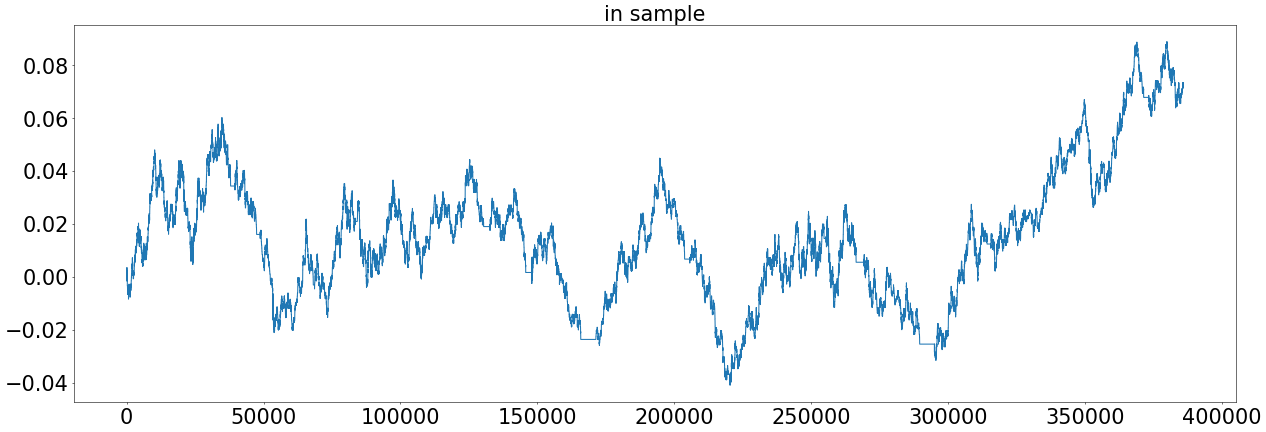

In [54]:
unrealized_return_train = unrealized(equity_value_1[(0.001, -0.0008, -0.015)], unrealized_1[(0.001, -0.0008, -0.015)])
plt.figure(figsize=(30,10),dpi=50)
plt.plot(unrealized_return_train)
plt.title('in sample', fontsize = 30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000., 400000., 450000.]),
 <a list of 11 Text xticklabel objects>)

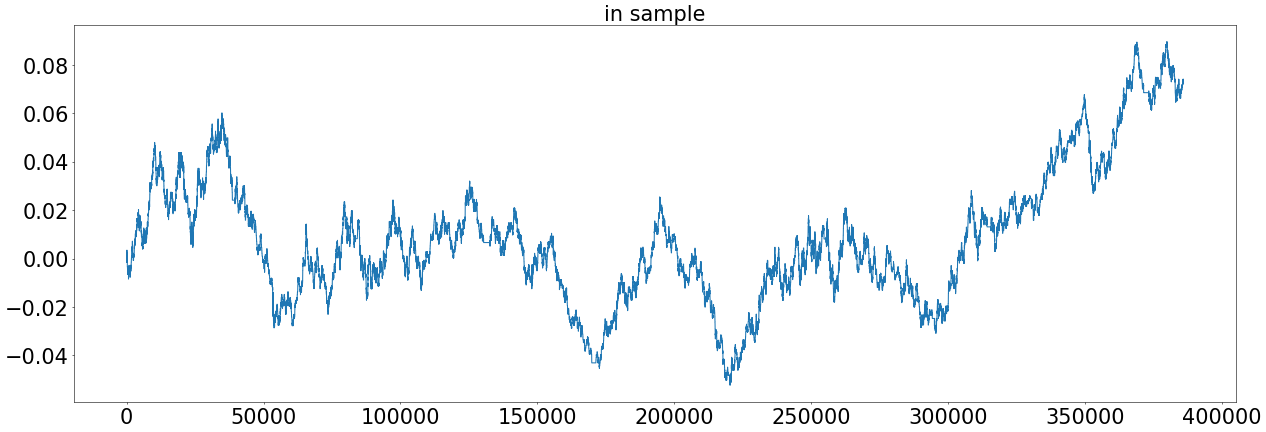

In [35]:
unrealized_return_train = unrealized(equity_value_1, unrealized_1)
plt.figure(figsize=(30,10),dpi=50)
plt.plot(unrealized_return_train)
plt.title('in sample', fontsize = 30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

In [36]:
performance(equity_value_1[['equity_value']], transaction_history1[(0.001, -0.0008, -0.025)])

return: 0.07190074328917527
std: 0.02549515984433481
sharp ratio: 2.616212006374089
trades: 82.0
odds ratio: 0.45121951219512196
mdd: 0.10035899023477118
skewness: 0.6966680774624747


(0.07190074328917527,
 0.02549515984433481,
 2.616212006374089,
 82.0,
 0.45121951219512196,
 0.10035899023477118,
 0.6966680774624747)

In [39]:
profit_col = [(0.0008, -0.0008, -0.015)]
equity_value_2, unrealized_2, transaction_history2 = strategy(df_test, profit_col)

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:550: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:552: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ip

(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
        120000.]),
 <a list of 8 Text xticklabel objects>)

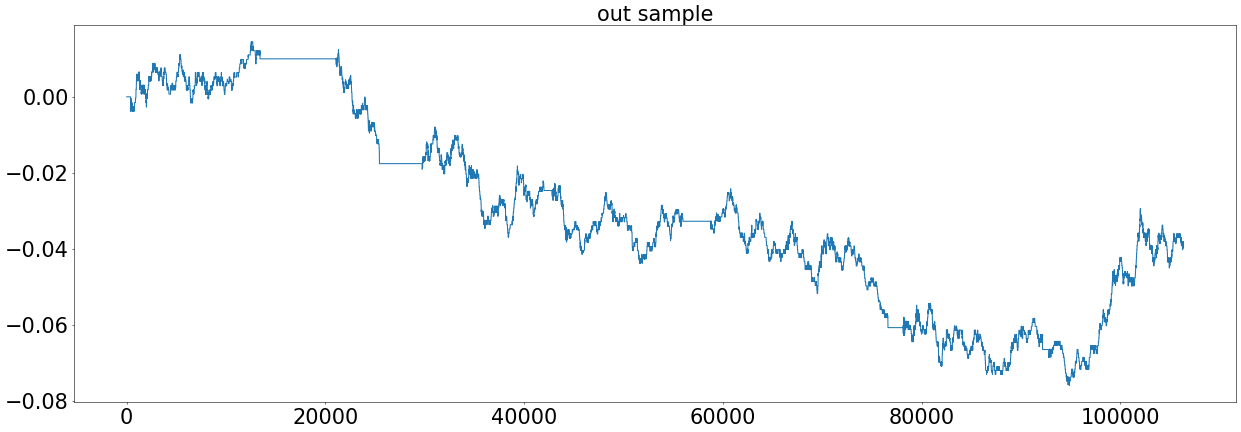

In [40]:
unrealized_return_test = unrealized(equity_value_2, unrealized_2)
plt.figure(figsize=(30,10),dpi=50)
plt.plot(unrealized_return_test)
plt.title('out sample', fontsize = 30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

In [41]:
performance(equity_value_2[['equity_value']], transaction_history2[(0.001, -0.0008, -0.025)])

return: -0.0419001408370589
std: 0.02542523258883303
sharp ratio: -1.8524959672441959
trades: 7.0
odds ratio: 0.2857142857142857
mdd: 0.07799042711354487
skewness: -0.0985314662100154


(-0.0419001408370589,
 0.02542523258883303,
 -1.8524959672441959,
 7.0,
 0.2857142857142857,
 0.07799042711354487,
 -0.0985314662100154)

In [22]:
profit_col = [(0.0008, -0.0008, -0.025),(0.0008, -0.0008, -0.015),(0.0008, -0.0008, -0.02)]
equity_value_2, unrealized_2, transaction_history2 = strategy(df_test, profit_col)

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:583: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:584: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ip

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:627: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:628: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
equity_value_2.columns = profit_col
unrealized_2.columns = profit_col

In [24]:
equity_value_2.iloc[-1]

(0.0008, -0.0008, -0.025)   -0.021434
(0.0008, -0.0008, -0.015)   -0.040225
(0.0008, -0.0008, -0.02)    -0.021434
Name: 106480, dtype: float64

In [25]:
performance(equity_value_2[[(0.0008, -0.0008, -0.02)]], transaction_history2[(0.0008, -0.0008, -0.02)])

return: -0.021433848144506912
std: 0.01578842784251159
sharp ratio: -1.686922118540085
trades: 19.0
odds ratio: 0.3684210526315789
mdd: 0.05621032186821866
skewness: -0.8025882631735516


(-0.021433848144506912,
 0.01578842784251159,
 -1.686922118540085,
 19.0,
 0.3684210526315789,
 0.05621032186821866,
 -0.8025882631735516)

In [46]:
performance(equity_value_2[[(0.001, -0.0008, -0.02)]], transaction_history2[(0.001, -0.0008, -0.02)])

return: -0.032068383275276995
std: 0.022042422045508422
sharp ratio: -1.6907571771529148
trades: 7.0
odds ratio: 0.2857142857142857
mdd: 0.06815866955176297
skewness: -0.07793388310048965


(-0.032068383275276995,
 0.022042422045508422,
 -1.6907571771529148,
 7.0,
 0.2857142857142857,
 0.06815866955176297,
 -0.07793388310048965)

(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
        120000.]),
 <a list of 8 Text xticklabel objects>)

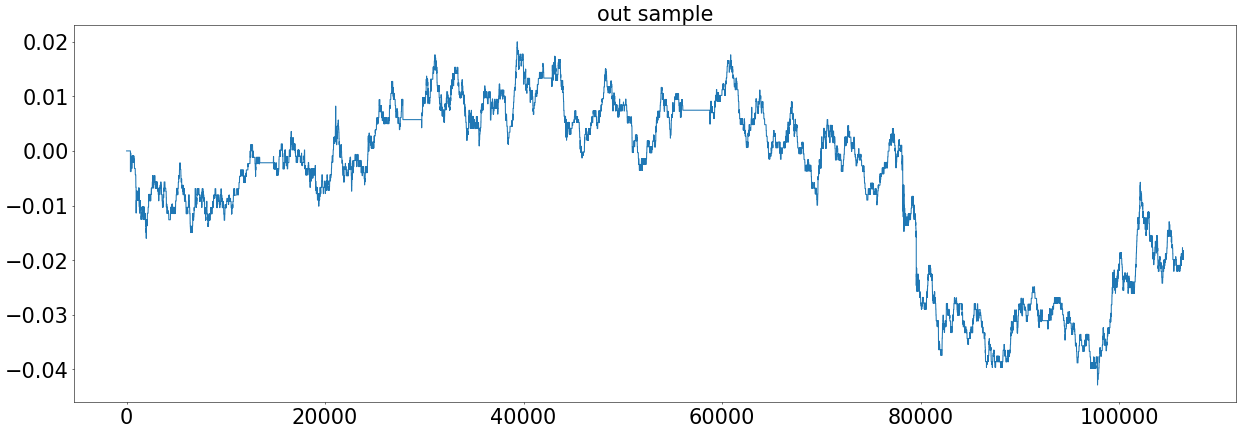

In [26]:
unrealized_return_test = unrealized(equity_value_2[(0.0008, -0.0008, -0.02)], unrealized_2[(0.0008, -0.0008, -0.02)])
plt.figure(figsize=(30,10),dpi=50)
plt.plot(unrealized_return_test)
plt.title('out sample', fontsize = 30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

In [60]:
df_test

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq2_dt_10,dbq3_dt_10,dbq4_dt_10,dbq5_dt_10,return_10t,pred_return,side,equity_value,unrealized,holding
0,0.0,0.0,1.0,437.0,437.5,5.0,3,436.5,438.0,15,...,-8.0,-2.0,-26.0,39.0,-0.000572,-0.000057,0.0,0.0,0.0,0.0
1,0.0,0.0,2.0,437.0,437.5,5.0,3,436.5,438.0,15,...,-8.0,-2.0,-27.0,39.0,-0.000572,-0.000046,0.0,0.0,0.0,0.0
2,0.0,0.0,3.0,437.0,437.5,5.0,3,436.5,438.0,15,...,-8.0,-2.0,-27.0,39.0,-0.000572,-0.000050,0.0,0.0,0.0,0.0
3,0.0,0.0,3.0,437.0,437.5,6.0,3,436.5,438.0,15,...,-8.0,-2.0,-27.0,39.0,0.000000,-0.000058,0.0,0.0,0.0,0.0
4,0.0,0.0,3.0,437.0,437.5,6.0,4,436.5,438.0,15,...,-7.0,-2.0,-27.0,39.0,0.000000,-0.000091,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106350,0.0,0.0,11.0,465.5,466.0,1.0,40,465.0,466.5,9,...,-9.0,-1.0,27.0,-65.0,0.000000,0.000062,0.0,0.0,0.0,0.0
106351,465.5,1.0,10.0,465.5,466.0,1.0,40,465.0,466.5,9,...,-9.0,-1.0,27.0,-65.0,0.000000,0.000035,0.0,0.0,0.0,0.0
106352,0.0,0.0,10.0,465.5,466.0,1.0,41,465.0,466.5,9,...,-8.0,-1.0,27.0,-65.0,0.000000,0.000025,0.0,0.0,0.0,0.0
106353,0.0,0.0,10.0,465.5,466.0,1.0,42,465.0,466.5,9,...,2.0,-4.0,0.0,0.0,0.000000,0.000025,0.0,0.0,0.0,0.0


In [28]:
profit_col_ = [(0.0008, -0.001, -0.025),(0.0008, -0.001, -0.015),(0.0008, -0.001, -0.02)]
equity_value_3, unrealized_3, transaction_history3 = strategy(df_test, profit_col_)

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:583: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\us

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:632: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:633: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:634: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [29]:
equity_value_3.columns = profit_col_
unrealized_3.columns = profit_col_

In [30]:
equity_value_3.iloc[-1]

(0.0008, -0.001, -0.025)    0.024481
(0.0008, -0.001, -0.015)    0.024481
(0.0008, -0.001, -0.02)     0.024481
Name: 106480, dtype: float64

In [31]:
performance(equity_value_3[[(0.0008, -0.001, -0.015)]], transaction_history3[(0.0008, -0.001, -0.015)])

return: 0.024480988715033805
std: 0.012330579113674517
sharp ratio: 1.5636726010420174
trades: 12.0
odds ratio: 0.4166666666666667
mdd: 0.020244657032020212
skewness: -0.7924936124736528


(0.024480988715033805,
 0.012330579113674517,
 1.5636726010420174,
 12.0,
 0.4166666666666667,
 0.020244657032020212,
 -0.7924936124736528)

(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
        120000.]),
 <a list of 8 Text xticklabel objects>)

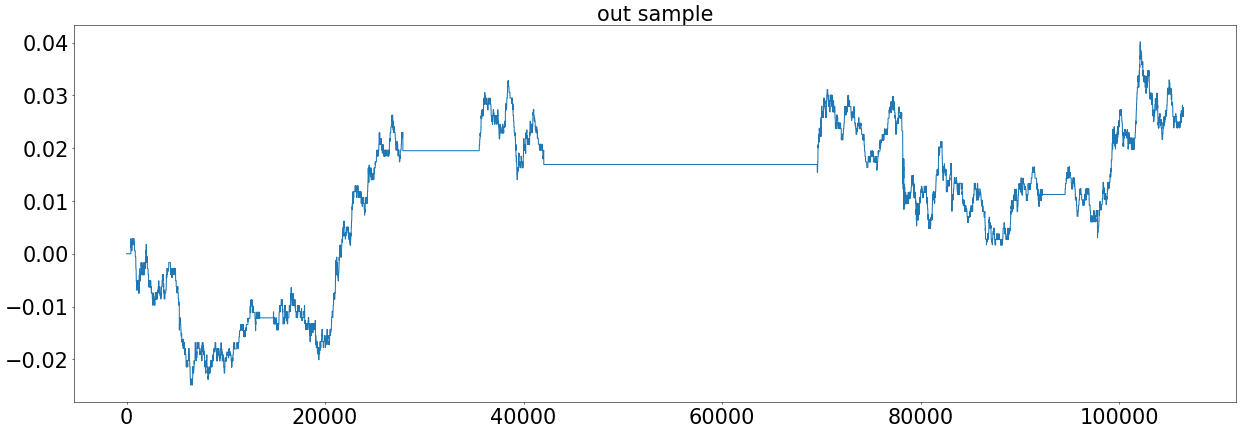

In [32]:
unrealized_return_test = unrealized(equity_value_3[(0.0008, -0.001, -0.015)], unrealized_3[(0.0008, -0.001, -0.015)])
plt.figure(figsize=(30,10),dpi=50)
plt.plot(unrealized_return_test)
plt.title('out sample', fontsize = 30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

In [35]:
data_train.Date.unique()

array(['2020-03-25', '2020-03-26', '2020-03-27', '2020-03-30',
       '2020-03-31', '2020-04-01', '2020-04-06', '2020-04-07',
       '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-13',
       '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
       '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23'],
      dtype=object)

In [36]:
data_test.Date.unique()

array(['2020-04-24', '2020-04-27', '2020-04-28', '2020-04-29',
       '2020-04-30', '2020-05-04', '2020-05-05'], dtype=object)